# Ionospheric Connection Explorer (ICON) on Jupyter Notebook

![caption](files/ICON_banner.png)
<br>
<br>
## Introduction of the science products 
- Access all data products and data documents on the website: <https://icon.ssl.berkeley.edu/Data>
- FTP site: <ftp://icon-science.ssl.berkeley.edu/pub>

The Ionospheric Connection Explorer, or ICON, is a new NASA Explorer mission
that will explore the boundary between Earth and space to understand the
physical connection between our world and our space environment. 
<br>
LEVEL.2 Data products included in this demo:
- L2.2 MIGHTI -- Neutral Vector Winds -- Zonal Wind & Meridional Wind 
- L2.3 MIGHTI-A/B* -- Neutral Temperature
- L2.4 FUV--Column O/$N_{2}$
- L2.5 FUV--Nighttime $O^{+}$ Density 
- L2.6 EUV--Daytime $O^{+}$ Density
- L2.7 IVM-A/B* -- Ion Drift/Ion Densities/Ion Temperature 
- A/B* are two identical instruments pointing to different directions.

### Note:
- Please read variable notes and quality flags for caveats, limitations, and best practices.
- The NetCDF files used here are only for demonstration. Please do not use the example data for publication - use official data sources instead.
- Binder (the interactive notebook launcher) is useful for preliminary explorations of the dataset. It will automatically shut down user sessions that have more than 10 minutes of inactivity.
- Any questions? yjwu@dn {dn=ssl.berkeley.edu}
<br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib
from datetime import datetime, timedelta
import bisect
import netCDF4

import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import pylab


plt.style.use('seaborn')
plt.rcParams.update({'font.size': 16,\
                     'xtick.labelsize' : 16,\
                     'ytick.labelsize' : 16,\
                     'axes.titlesize' : 23,\
                     'axes.labelsize' : 20})

In [2]:
def argwhere_2D(target_array,argwhere_target):
    new_array=np.zeros(np.shape(target_array))+np.nan
    arg_ysize,arg_xsize=np.shape(argwhere_target)
    for i in range(0,arg_ysize):
        new_array[argwhere_target[i,0],argwhere_target[i,1]]=target_array[argwhere_target[i,0],argwhere_target[i,1]]
    return new_array


class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

# 1. IVM-FUV/EUV
- DP 2.6 and 2.7 both provide ion density:
 - 2.6 from EUV: Remotely sensed O+ profile on the limb.
 - 2.7 from IVM: In-situ ion density, temperature, and composition at S/C altitude (~600 km)
- In-situ ion density/drift by IVM and O+ density by EUV/FUV along the same mag-field line.

In [3]:
fn_L26 ='Example_L26_EUV.NC'
fn_L27 ='Example_L27_IVM.NC'


# Load L2.6 Daytime plasma observations #
dEUV = {}
with netCDF4.Dataset(fn_L26) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dEUV['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dEUV['HmF2']  = np.ma.filled(d.variables['ICON_L26_HmF2'][...], np.nan) 
    dEUV['NmF2']  = np.ma.filled(d.variables['ICON_L26_NmF2'][...], np.nan) 
    dEUV['Oplus']  = np.ma.filled(d.variables['ICON_L26_Oplus'][...], np.nan)
    dEUV['orb_num']  = np.ma.filled(d.variables['ICON_L26_Orbit_Number'][...], np.nan) 

    dEUV['tang_slt']   = np.ma.filled(d.variables['ICON_L26_Local_Solar_Time'][...], np.nan) 
    dEUV['tang_lon']   = np.ma.filled(d.variables['ICON_L26_Longitude'][...], np.nan) 
    dEUV['tang_lat']   = np.ma.filled(d.variables['ICON_L26_Latitude'][...], np.nan) 
    dEUV['tang_alt']   = np.ma.filled(d.variables['ICON_L26_Altitude'][...], np.nan) 

    dEUV['tang_mlon']   = np.ma.filled(d.variables['ICON_L26_Magnetic_Longitude'][...], np.nan) 
    dEUV['tang_mlat']   = np.ma.filled(d.variables['ICON_L26_Magnetic_Latitude'][...], np.nan) 

    # Simple quality control
    L26_flag  = np.ma.filled(d.variables['ICON_L26_Flags'][...], np.nan) 
    good_data = ( L26_flag == 0)|( L26_flag == 1 ) # Allow L26_flag=0 and 1. 0 =No issues reported, 1 = Moderate issue(s) identified, use results with caution, 2 = Severe issue(s) identified.,
    dEUV['HmF2'][~good_data] = np.nan
    dEUV['NmF2'][~good_data] = np.nan
    dEUV['Oplus'][~good_data,:] = np.nan

#### Load ion velocity
di = {}
with netCDF4.Dataset(fn_L27) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    di['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    di['vmer']  = np.ma.filled(d.variables['ICON_L27_Ion_Velocity_Meridional'][...], np.nan) # Mag Meridional (Upward/poleward) ion velocity
    di['Ni']  = np.ma.filled(d.variables['ICON_L27_Ion_Density'][...], np.nan) 

    di['mlat']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Latitude'][...], np.nan) 
    di['mlon']  = np.ma.filled(d.variables['ICON_L27_Magnetic_Longitude'][...], np.nan) 
    di['slt']   = np.ma.filled(d.variables['ICON_L27_Solar_Local_Time'][...], np.nan) 
    di['alt']   = np.ma.filled(d.variables['ICON_L27_Altitude'][...], np.nan) 
    di['lon']   = np.ma.filled(d.variables['ICON_L27_Longitude'][...], np.nan) 
    di['lat']   = np.ma.filled(d.variables['ICON_L27_Latitude'][...], np.nan) 

    di['orb_num']   = np.ma.filled(d.variables['ICON_L27_Orbit_Number'][...], np.nan) # Local solar time

#     In latest released version v02r002, use the flags below
    DM_flag   = np.ma.filled(d.variables['ICON_L27_DM_Flag'][...], np.nan) # Quality control variable for Drift Meter
    RPA_flag  = np.ma.filled(d.variables['ICON_L27_RPA_Flag'][...], np.nan) # Quality control variable for RPA
    good_data = (DM_flag == 0) & (RPA_flag < 2)
    di['Ni'][~good_data] = np.nan
    

print('Range of the orbit number: %04i to %04i' % (np.nanmin(di['orb_num']),np.nanmax(di['orb_num'])))

Range of the orbit number: 2197 to 2212


In [4]:
# Select a particular orbit
target_orbit_num = 2200
# data cadence= 1 second
shift_epoch=360*4# <0: move window to the earlier epoch,>0: move window to the later epoch

di_select_orb_num_idx = np.argwhere(di['orb_num']== target_orbit_num)
di_select_idx = di_select_orb_num_idx[:,0]+shift_epoch

select_di = {}
select_di['orb_num'] = di['orb_num'][di_select_idx]
select_di['time']    = di['time'][di_select_idx]
select_di['Ni']      = di['Ni'][di_select_idx]
select_di['vmer']    = di['vmer'][di_select_idx]
select_di['slt']  = di['slt'][di_select_idx]
select_di['lon']  = di['lon'][di_select_idx]
select_di['lat']  = di['lat'][di_select_idx]
select_di['mlon'] = di['mlon'][di_select_idx]
select_di['mlat'] = di['mlat'][di_select_idx]


dEUV_select_idx=np.where((dEUV['time']>=select_di['time'][0]) & (dEUV['time'] < select_di['time'][-1]))
select_dEUV = {}
select_dEUV['orb_num'] = dEUV['orb_num'][dEUV_select_idx]
select_dEUV['time']    = dEUV['time'][dEUV_select_idx]
select_dEUV['Oplus']   = dEUV['Oplus'][dEUV_select_idx,:][0,:,:].transpose()
select_dEUV['HmF2']    = dEUV['HmF2'][dEUV_select_idx]
select_dEUV['NmF2']    = dEUV['NmF2'][dEUV_select_idx]

select_dEUV['tang_slt'] = dEUV['tang_slt'][dEUV_select_idx]
select_dEUV['tang_lon'] = dEUV['tang_lon'][dEUV_select_idx]
select_dEUV['tang_lat'] = dEUV['tang_lat'][dEUV_select_idx]
select_dEUV['tang_alt'] = dEUV['tang_alt'][dEUV_select_idx,:][0,:,:].transpose()
select_dEUV['tang_mlon'] = dEUV['tang_mlon'][dEUV_select_idx]
select_dEUV['tang_mlat'] = dEUV['tang_mlat'][dEUV_select_idx]

print('Selected time: %s to %s' % (select_di['time'][0].strftime("%m-%d-%y %H:%M:%S"),select_di['time'][-1].strftime("%m-%d-%y %H:%M:%S")))


Selected time: 03-06-20 05:01:54 to 03-06-20 06:38:11


## In-situ ion density and NmF2 at tangent points

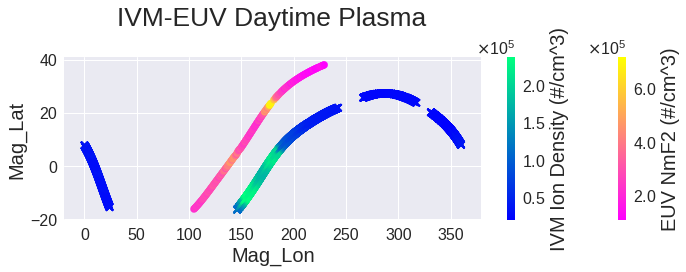

In [5]:
plt.close()
plt.rcParams.update({'font.size': 22})
fig,ax=plt.subplots(figsize=(10,4))#fig=pp.figure(figsize=(12,10)
fig.suptitle('IVM-EUV Daytime Plasma',x=0.4)

im=plt.scatter(select_dEUV['tang_mlon'],select_dEUV['tang_mlat'],c=select_dEUV['NmF2'],cmap='spring')
color_bar=fig.colorbar(im, format=OOMFormatter(5, mathText=True))
color_bar.set_label('EUV NmF2 (#/cm^3)')
 


im=plt.scatter(select_di['mlon'],select_di['mlat'],c=select_di['Ni'],cmap='winter',marker='x')
color_bar=fig.colorbar(im, format=OOMFormatter(5, mathText=True))

color_bar.set_label('IVM Ion Density (#/cm^3)')

plt.xlabel('Mag_Lon')
plt.ylabel('Mag_Lat')
# plt.xlim([100,250]) # Zoom in to 100 <mlon< 250
plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])


## In-situ ion density and O+ density profilt at tangent points

/home/yjwu/miniconda3/envs/my_conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/yjwu/miniconda3/envs/my_conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


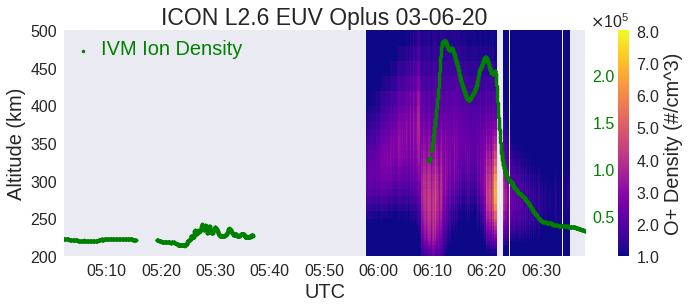

In [6]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### IVM Ion Density ####
di_good_idx=np.argwhere((np.abs(select_di['Ni'])<10**7))
target_2_array=select_di['Ni'][di_good_idx]
X_2_array=select_di['time'][di_good_idx]
show_time=select_di['time'][di_good_idx]

## EUV Oplus ###
X_1_array=np.zeros(np.shape(select_dEUV['Oplus']),dtype=object)
t_ysize,t_xsize=np.shape(select_dEUV['Oplus'])
for i in range(0,t_ysize):
    X_1_array[i,:]=select_dEUV['time']
    
dEUV_good_idx=np.argwhere((np.abs(select_dEUV['Oplus'])<10**7) )
Y_1_array=argwhere_2D(select_dEUV['tang_alt'],dEUV_good_idx)
target_1_array=argwhere_2D(select_dEUV['Oplus'],dEUV_good_idx)

cmap_1='plasma'
vmax_1=8*10**5
vmin_1=1*10**5
variable_name_1='ICON L2.6 EUV Oplus %s' % show_time[0,0].strftime("%m-%d-%y")
xlabel_1='UTC'
ylabel_1='Altitude (km)'
cb_label_1='O+ Density (#/cm^3)'

######################## PLOT #############################

fig,ax=plt.subplots(figsize=(10,5))#fig=pp.figure(figsize=(12,10)


gs = gridspec.GridSpec(1, 1) 

ax0=plt.subplot(gs[0,0])
im = ax0.pcolor(X_1_array,Y_1_array,target_1_array ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.set_ylim([200,500])
ax0.set_xlim([show_time[0],show_time[-1]])
ax0.set_title(variable_name_1)
ax0.set_xlabel(xlabel_1)
ax0.set_ylabel(ylabel_1)
color_bar=fig.colorbar(im,format=OOMFormatter(5, mathText=True))
color_bar.set_label(cb_label_1)

ax2 = ax0.twinx()
ax2.plot(X_2_array,target_2_array/100000.,'g.',label='IVM Ion Density')
ax2.grid(None)
leg=plt.legend(loc='best')
for text in leg.get_texts():
    plt.setp(text, color = 'g',size=20)
ax2.tick_params(axis='y', colors="g")
ax0.set_xlim([show_time[0],show_time[-1]])

myFmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])


# 2. IVM-MIGHTI  - Neutral wind driven electrodynamic interactions
- Once per orbit, ICON crosses the equator in the daytime.
- IVM measures the vertical drift at the equator
- MIGHTI measures the wind profile at the northern footpoint of the magnetic field line.


In [7]:
fn_L22 ='Example_L22_Wind.NC'

### Load winds
dm = {}
with netCDF4.Dataset(fn_L22) as d:
    time_msec  = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dm['time_ms'] = time_msec
    dm['time'] = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dm['orb_num']  = np.ma.filled(d.variables['ICON_L22_Orbit_Number'][...], np.nan)

    dm['uzon'] = np.ma.filled(d.variables['ICON_L22_Zonal_Wind'][...], np.nan) #>0: Eastward, <0: Westward
    dm['umer'] = np.ma.filled(d.variables['ICON_L22_Meridional_Wind'][...], np.nan) #>0: northward, <0: southward
    dm['tang_alt']  = np.ma.filled(d.variables['ICON_L22_Altitude'][...], np.nan)
    dm['tang_lon']  = np.ma.filled(d.variables['ICON_L22_Longitude'][...], np.nan)
    dm['tang_lat']  = np.ma.filled(d.variables['ICON_L22_Latitude'][...], np.nan)
    dm['tang_slt']  = np.ma.filled(d.variables['ICON_L22_Local_Solar_Time'][...], np.nan)
    
    # Simple quality control
    wind_quality = np.ma.filled(d.variables['ICON_L22_Wind_Quality'][...], np.nan)
    good_data = wind_quality == 1
    dm['uzon'][~good_data] = np.nan
    dm['umer'][~good_data] = np.nan


print('Range of the orbit number: %04i to %04i' % (np.nanmin(dm['orb_num']),np.nanmax(dm['orb_num'])))

Range of the orbit number: 2197 to 2212


In [8]:
#### Find first equator crossing during daytime 
icon_near_equator = (abs(di['mlat']) < 1.) # ICON is within 1 degree of equator
daytime = abs(di['slt'] - 12) < 6 # ICON is in daytime hours
ii = np.where( icon_near_equator & daytime )[0][0] # index of first IVM sample
t0 = di['time'][ii]
print('ICON near equator starting at %s' % t0)

# Find MIGHTI index that matches this time
# Note: in practice, the true MIGHTI-IVM conjunction may happen a couple minutes before or after this time.
# Magnetic field line tracing is recommended to find true conjunctions.
im_idx = np.argmin(abs(dm['time'] - t0))

ICON near equator starting at 2020-03-06 01:27:28.224000


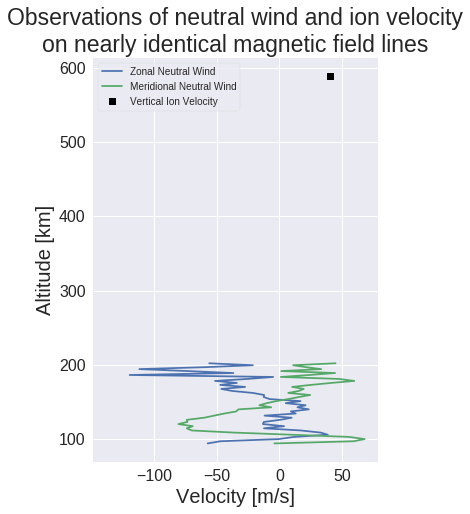

In [9]:
#### Plot the profiles ###
plt.close()
plt.figure(figsize=(6,8))

plt.plot(dm['uzon'][im_idx,:], dm['tang_alt'], 'C0-', label='Zonal Neutral Wind')
plt.plot(dm['umer'][im_idx,:], dm['tang_alt'], 'C1-', label='Meridional Neutral Wind')
plt.plot(di['vmer'][ii], di['alt'][ii], 'ks', label='Vertical Ion Velocity')
plt.ylabel('Altitude [km]')
plt.xlabel('Velocity [m/s]')
plt.title('Observations of neutral wind and ion velocity\non nearly identical magnetic field lines')
# plt.ylim([90,250])
plt.legend(frameon=True)
plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])

# 3. Plot a single orbit--use L2.3 Temperature and L2.2 Vector Winds as an example

In [10]:
MTAB='A'
fn_L23 ='Example_L23_Temperature.NC'

#### Load Temperature ###
dTN = {}
with netCDF4.Dataset(fn_L23) as d:
    time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
    dTN['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
    dTN['TN']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Temperature' % (MTAB)][...], np.nan) 
    dTN['mlat']  = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Magnetic_Longitude' % (MTAB)][...], np.nan) 
    dTN['tang_slt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Solar_Local_Time' % (MTAB)][...], np.nan) 
    dTN['tang_alt']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Altitude' % (MTAB)][...], np.nan) 
    dTN['tang_lat']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Latitude' % (MTAB)][...], np.nan) 
    dTN['tang_lon']   = np.ma.filled(d.variables['ICON_L23_MIGHTI_%s_Tangent_Longitude' % (MTAB)][...], np.nan) 

    dTN['SC_lat']   = np.ma.filled(d.variables['ICON_L23_Observatory_Latitude'][...], np.nan) 
    dTN['SC_lon']   = np.ma.filled(d.variables['ICON_L23_Observatory_Longitude'][...], np.nan) 

    dTN['orb_num'] = np.ma.filled(d.variables['ICON_L23_Orbit_Number'][...], np.nan)

    # Simple quality control
    saa_flag  = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_South_Atlantic_Anomaly' % (MTAB)][...], np.nan) # SAA flag
    cali_flag = np.ma.filled(d.variables['ICON_L1_MIGHTI_%s_Quality_Flag_Bad_Calibration' % (MTAB)][...], np.nan) # Calibration flag

    good_data = (saa_flag == 0) & (cali_flag == 0)# 
    dTN['TN'][:,~good_data] = np.nan # only good data are shown

print('Range of the orbit number in L2.3: %04i to %04i' % (np.nanmin(dTN['orb_num']),np.nanmax(dTN['orb_num'])))

Range of the orbit number in L2.3: 2197 to 2212


In [11]:
# Select a particular orbit
target_orbit_num = 2211
shift_epoch=-50# <0: move window to the earlier epoch,>0: move window to the later epoch

dTN_select_orb_num_idx = np.argwhere(dTN['orb_num']== target_orbit_num)
dTN_select_idx = dTN_select_orb_num_idx[:,0]+shift_epoch

select_dTN = {}
select_dTN['orb_num'] = dTN['orb_num'][dTN_select_idx]
select_dTN['time']    = dTN['time'][dTN_select_idx]
select_dTN['TN']      = dTN['TN'][:,dTN_select_idx]
select_dTN['tang_slt']      = dTN['tang_slt'][:,dTN_select_idx]
select_dTN['tang_lon'] = dTN['tang_lon'][:,dTN_select_idx]
select_dTN['tang_lat'] = dTN['tang_lat'][:,dTN_select_idx]
select_dTN['tang_alt'] = dTN['tang_alt'][:,dTN_select_idx]


dm_select_idx=np.where((dm['time']>=select_dTN['time'][0]) & (dm['time'] < select_dTN['time'][-1]))
select_dm = {}
select_dm['orb_num'] = dm['orb_num'][dm_select_idx]
select_dm['time']    = dm['time'][dm_select_idx]
select_dm['uzon']    = dm['uzon'][dm_select_idx,:][0,:,:].transpose()
select_dm['umer']    = dm['umer'][dm_select_idx,:][0,:,:].transpose()
select_dm['tang_slt']      = dm['tang_slt'][dm_select_idx,:][0,:,:].transpose()
select_dm['tang_lon'] = dm['tang_lon'][dm_select_idx,:][0,:,:].transpose()
select_dm['tang_lat'] = dm['tang_lat'][dm_select_idx,:][0,:,:].transpose()
select_dm['tang_alt'] = dm['tang_alt'][:]

print('Selected time: %s to %s' % (select_dTN['time'][0].strftime("%m-%d-%y %H:%M:%S"),select_dTN['time'][-1].strftime("%m-%d-%y %H:%M:%S")))


Selected time: 03-06-20 21:52:22 to 03-06-20 23:24:38


/home/yjwu/miniconda3/envs/my_conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


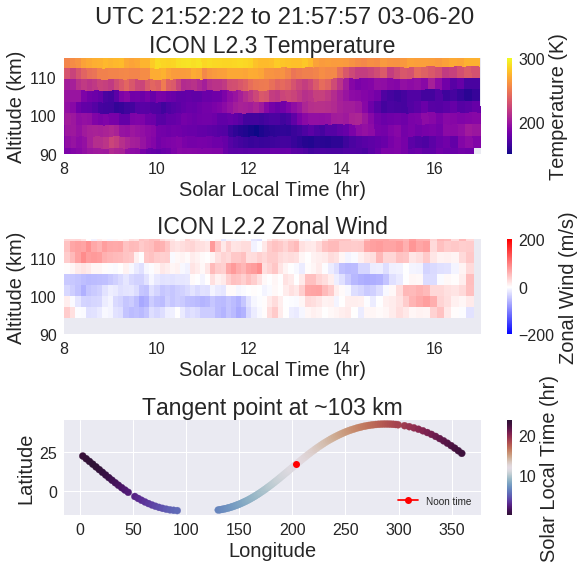

In [12]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdatesa

dTN_good_idx=np.argwhere((np.abs(select_dTN['TN'])<5000) & (np.abs(select_dTN['tang_slt']-12.) <5.))
dm_good_idx=np.argwhere((np.abs(select_dm['uzon'])<5000) & (np.abs(select_dm['tang_slt']-12.) <5.))

## Temperature ###

target_1_array=argwhere_2D(select_dTN['TN'],dTN_good_idx)
X_1_array=argwhere_2D(select_dTN['tang_slt'],dTN_good_idx)
Y_1_array=argwhere_2D(select_dTN['tang_alt'],dTN_good_idx)


cmap_1='plasma'
vmax_1=300
vmin_1=150
variable_name_1='ICON L2.3 Temperature'
xlabel_1='Solar Local Time (hr)'
ylabel_1='Altitude (km)'
cb_label_1='Temperature (K)'
tang_alt_idx=5


## Wind ###

target_2_array=argwhere_2D(select_dm['uzon'],dm_good_idx)
X_2_array=argwhere_2D(select_dm['tang_slt'],dm_good_idx)
t2_ysize,t2_xsize=np.shape(target_2_array)
Y_2_array=np.zeros(np.shape(target_2_array))
for i in range(0,t2_xsize):
    Y_2_array[:,i]=select_dm['tang_alt']

NC_fname_split=re.split('/|.NC',fn_L22)
plot_fname=NC_fname_split[-2]
cmap_2='bwr'
vmax_2=200
vmin_2=-200
variable_name_2='ICON L2.2 Zonal Wind'
xlabel_2='Solar Local Time (hr)'
ylabel_2='Altitude (km)'
cb_label_2='Zonal Wind (m/s)'

######################## PLOT #############################
show_time=select_dTN['time'][dTN_good_idx]

fig,ax=plt.subplots(figsize=(8,8))#fig=pp.figure(figsize=(12,10)

fig.suptitle('UTC %s to %s' % (show_time[0,0].strftime("%H:%M:%S"),show_time[-1,0].strftime("%H:%M:%S %m-%d-%y")),size=24,x=0.5)
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 

ax0=plt.subplot(gs[0,0])
im = ax0.pcolor(X_1_array,Y_1_array,target_1_array ,cmap=cmap_1,vmin=vmin_1,vmax=vmax_1)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.axis([8,17,90,115])
ax0.set_title(variable_name_1)
ax0.set_xlabel(xlabel_1)
ax0.set_ylabel(ylabel_1)
color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_1)

ax0=plt.subplot(gs[1,0])
im = ax0.pcolor(X_2_array,Y_2_array,target_2_array ,cmap=cmap_2,vmin=vmin_2,vmax=vmax_2)#,norm=colors.Normalize(vmin=0, vmax=150))
ax0.axis([8,17,90,115])
ax0.set_title(variable_name_2)
ax0.set_xlabel(xlabel_2)
ax0.set_ylabel(ylabel_2)
color_bar=fig.colorbar(im)
color_bar.set_label(cb_label_2)

ax0=plt.subplot(gs[2,0])
im=ax0.scatter(select_dTN['tang_lon'][tang_alt_idx,:],select_dTN['tang_lat'][tang_alt_idx,:],c=select_dTN['tang_slt'][tang_alt_idx,:],cmap='twilight_shifted')
ax0.set_title('Tangent point at ~%03i km' % select_dTN['tang_alt'][tang_alt_idx,1])
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')

noon_idx=np.argmin(np.abs(select_dTN['tang_slt'][tang_alt_idx,:]-12))
noon_lon=select_dTN['tang_lon'][tang_alt_idx,noon_idx]
noon_lat=select_dTN['tang_lat'][tang_alt_idx,noon_idx]
ax0.plot(noon_lon,noon_lat,marker='o',color='red',label='Noon time')
color_bar=fig.colorbar(im)
color_bar.set_label('Solar Local Time (hr)')

plt.tight_layout(rect=[0, 0.0, 1.05, 0.95])

plt.legend(loc='lower right')

In [1]:

# #  Load L2.4 disk O/N2 #
# dON2 = {}
# with netCDF4.Dataset(fn_L24) as d:
#     time_msec   = np.ma.filled(d.variables['Epoch'][...], np.nan) # Time in msec since 1970-01-01
#     dON2['time']  = np.array([datetime(1970,1,1) + timedelta(seconds = 1e-3*s) for s in time_msec])
#     dON2['disk_ON2']  = np.ma.filled(d.variables['ICON_L24_disk_ON2'][...], np.nan) 
#     dON2['disk_slt']   = np.ma.filled(d.variables['ICON_L24_Local_Solar_Time_Disk'][...], np.nan)
#     dON2['disk_lon']   = np.ma.filled(d.variables['ICON_L24_disk_longitude'][...], np.nan) 
#     dON2['disk_lat']   = np.ma.filled(d.variables['ICON_L24_disk_latitude'][...], np.nan) 
#     dON2['SC_lon']   = np.ma.filled(d.variables['ICON_L24_Observatory_Longitude'][...], np.nan)
#     dON2['SC_lat']   = np.ma.filled(d.variables['ICON_L24_Observatory_Latitude'][...], np.nan) 

#     # Simple quality control
#     model_flag  = np.ma.filled(d.variables['ICON_L24_Model_Disk_Flags'][...], np.nan) 
#     instrument_flag  = np.ma.filled(d.variables['ICON_L24_Instrument_Mode_Flag'][...], np.nan) 
#     L1_flag = np.ma.filled(d.variables['ICON_L24_Level_1_Quality_Flag'][...], np.nan) 
#     good_data = ( model_flag[:,0] == 0) & ( instrument_flag == 1) & ( L1_flag== 0)
#     dON2['disk_lon'][~good_data] = np.nan
# # dON2_select_orb_num_idx = np.argwhere(dON2['orb_num']== target_orbit_num)
# dON2_select_idx = dON2_select_orb_num_idx[:,0]+shift_epoch

# select_dON2 = {}
# select_dON2['orb_num'] = dON2['orb_num'][dON2_select_idx]
# select_dON2['time']    = dON2['time'][dON2_select_idx]
# select_dON2['disk_ON2']     = dON2['disk_ON2'][dON2_select_idx]
# select_dON2['disk_slt']      = dON2['disk_slt'][dON2_select_idx]
# select_dON2['disk_lon'] = dON2['disk_lon'][dON2_select_idx]
# select_dON2['disk_lat'] = dON2['disk_lat'][dON2_select_idx]

